# Lab 3 — dimensionality reduction

In [24]:
import json
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la

from operator import itemgetter
from operator import add

%matplotlib inline
plt.style.use("ggplot")

!hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 2

In [36]:
!hdfs dfs -cat /ix/ml-20m/genome-scores.txt | tail -n 2

{"relevance": 0.11449999999999999, "tagId": 1127, "movieId": 131170}
{"relevance": 0.02174999999999999, "tagId": 1128, "movieId": 131170}


In [130]:
data = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
tag2name = dict(data.map(itemgetter("tagId", "tag")).collect())
name2tag = {v: k for k, v in tag2name.items()}
# Number of tags
print('There is %d tags'%data.count())

There is 1128 tags


230

In [3]:
data = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
# Number of movies
print('There is %d movies'%data.count())
# Shortest title
print(data.map(lambda movie: (len(movie['title']),movie['title'])).reduce(min))
# Longest title
print(data.map(lambda movie: (len(movie['title']),movie['title'])).reduce(max))

There is 27278 movies
(8, '1 (2013)')
(191, 'Godzilla, Mothra, and King Ghidorah: Giant Monsters All-Out Attack (Gojira, Mosura, Kingu Gidorâ: Daikaijû sôkôgeki) (Godzilla, Mothra and King Ghidorah: Giant Monsters All-Out Attack) (2001)')


In [4]:
data = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)
distinctMovies = data.map(lambda score: score['movieId']).distinct().count()
print('There is %d movies with tags'%distinctMovies)
distinctTags = data.map(lambda score: score['tagId']).distinct().count()
print('There is %d distinct tags'%distinctTags)

There is 10381 movies with tags
There is 1128 distinct tags


In [14]:
data = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)
movie2Idx = data.map(lambda score: score['movieId']).distinct().zipWithIndex().collectAsMap()
idx2movie = {v: k for k, v in movie2Idx.items()}

In [16]:
matrix = np.zeros((distinctTags,distinctMovies),dtype=np.float64)
for score in data.map(lambda score: (score['movieId'],score['tagId'],score['relevance'])).collect():
    matrix[score[1]-1,movie2Idx[score[0]]] = score[2]

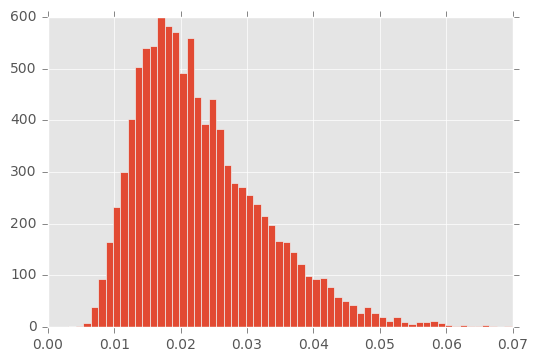

In [40]:
variance = np.var(matrix,0)
plt.hist(variance,'auto');
varianceTot = np.sum(variance)

In [74]:
matrix.shape

(1128, 10381)

In [84]:
# Check 
eigenvalues, eigenvectors = la.eigh(np.cov(matrix))
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

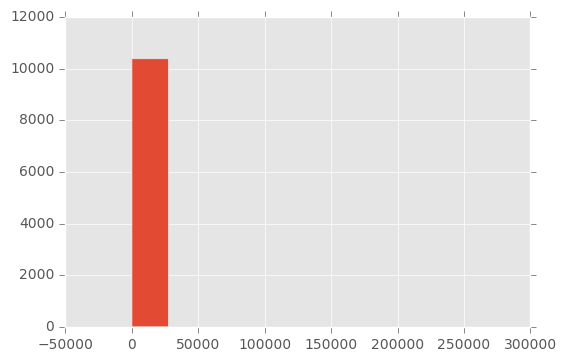

In [85]:
targetVar = 2/3.0 * np.sum(eigenvalues)
n = 0
sumVar = 0
for eigenvalue in eigenvalues:
    sumVar += eigenvalue
    n += 1
    if sumVar >= targetVar:
        break
print("We need %d principal direction to capture 2/3 of the variability"%(n))

We need 37 principal direction to capture 2/3 of the variability


In [96]:
V = eigenvectors[:,:5]
smallest = eigenvectors[:,0].argsort()[:10]

[0.10458698975761184,
 0.10185325816492775,
 0.10138878364995314,
 0.09990640035526184,
 0.098764320942253458,
 0.098425206601210652,
 0.097419252922881963,
 0.096656463697373088,
 0.096185828420326913,
 0.095898270227488175]

In [141]:
data = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
tagName2PCA = {}
for tag in data.map(lambda tag: (tag['tag'],tag['tagId'])).collect():
   tagName2PCA[tag[0]] = V[tag[1]-1]
np.save('tag2pca',tagName2PCA)

In [125]:
goodTags = np.empty((5, 10),dtype=object)
badTags = np.empty((5, 10),dtype=object)
for i in range (0,5):
    good = eigenvectors[:,i].argsort()[-10:][::-1]
    for idx, val in enumerate(good):
        goodTags[i][idx] = tag2name[val+1]
    bad = eigenvectors[:,i].argsort()[:10]
    for idx, val in enumerate(bad):
        badTags[i][idx] = tag2name[val+1]

In [137]:
print(goodTags)
print("Bad:")
print(badTags)

[['talky' 'social commentary' 'criterion' 'imdb top 250' 'great acting'
  'drama' 'oscar (best directing)' 'bleak' 'dramatic' 'cinematography']
 ['intimate' 'relationships' 'criterion' 'melancholic' 'loneliness'
  'golden palm' 'meditative' 'art house' 'melancholy' 'sexual']
 ['feel-good' 'sentimental' 'love story' 'heartwarming' 'touching'
  'romantic' 'sweet' 'courage' 'girlie movie' 'feel good movie']
 ['visual' 'visually stunning' 'imagination' 'sci-fi' 'scifi'
  'visually appealing' 'science fiction' 'sci fi' 'special effects'
  'beautifully filmed']
 ['thriller' 'conspiracy' 'secrets' 'suspenseful' 'tense' 'mystery'
  'suspense' 'investigation' 'murder mystery' 'betrayal']]
Bad:
[['predictable' "so bad it's funny" 'bad plot' 'silly' 'silly fun'
  'horrible' 'franchise' 'lame' 'big budget' 'comedy']
 ['action' 'special effects' 'big budget' 'chase' 'fast paced' 'suspense'
  'good action' 'plot' 'pg-13' 'action packed']
 ['horror' 'weird' 'creepy' 'splatter' 'stylish' 'cult classic